In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================
# -- Copied from lecture
%load_ext autoreload
%config IPCompleter.greedy=True
%autoreload 1
%aimport util
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from util import util

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)


# Load the datasets
data_train = util.load_dataset('7_gecco2019_train_water_quality.csv')
data_val = util.load_dataset('8_gecco2019_valid_water_quality.csv')
data_test = util.load_dataset('6_gecco2019_test_water_quality.csv')

# Fill missing values
data_train = util.impute_missing_values(data_train)
data_val = util.impute_missing_values(data_val)
data_test = util.impute_missing_values(data_test)

# Get the feature columns
feature_columns = util.get_feature_columns(data_train)

# Distribution and Detrending
Understanding the distribution and global trends of the data is important for choosing the right preprocessing steps and models for contamination detection. In this notebook, we will explore the distribution of the features and the trends in the data. We will finally apply detrending to the data to remove the trends and focus on the remaining features.

## Autocorrelation Plot
Let's have a look at the autocorrelation plot for the entire dataset again. It shows that for a few features, there is a significant temporal correlation. This can have a negative impact on the performance of the models because many models are based on the assumption of independent observations. Additionally, when data points are closely linked in time, it becomes harder to distinguish genuine trends from noise which makes it challenging to identify true causal relationships.

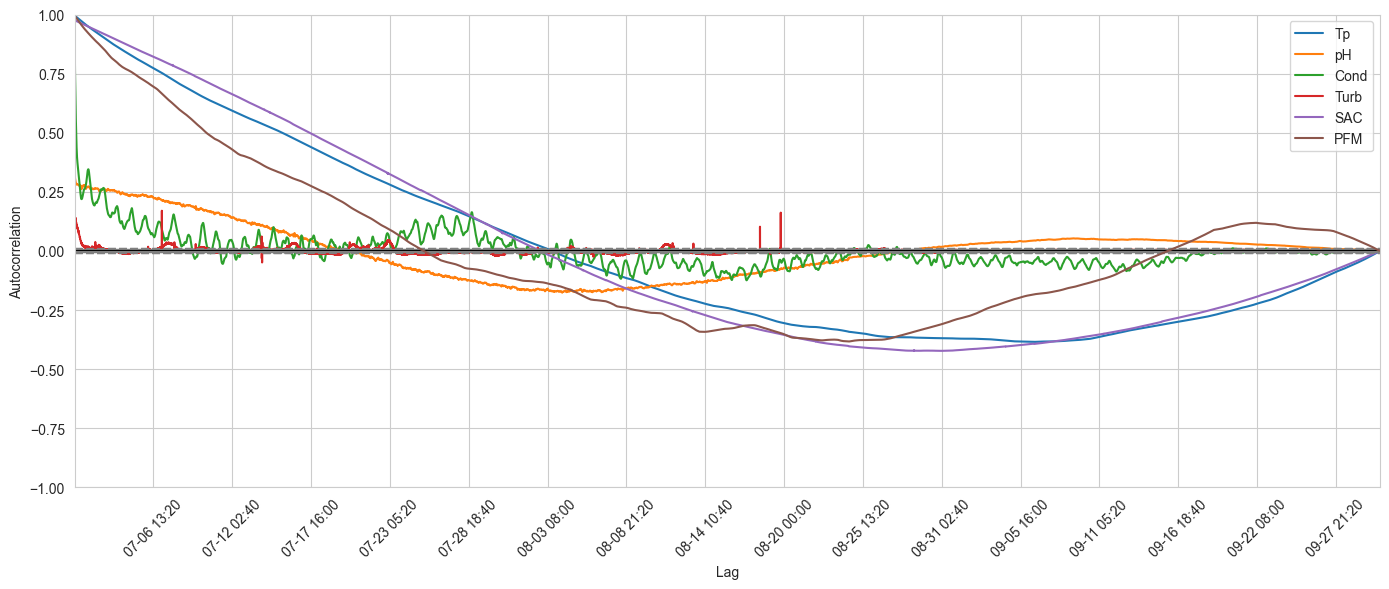

In [2]:
# Prepare the data for the autocorrelation plot
sample_delta = (data_train.index[1] - data_train.index[0])
data_autocorrelation = [data_train[c] for c in feature_columns]

# Plot the autocorrelation for each feature
util.plot_multiple_autocorrelations(data_autocorrelation, figsize=(figsize[0], 6))

## Visualizing the Trends for each Feature
These trends can also be observed in the visualization of the features. For example, the `Tp` feature shows a clear sine wave like trend over time and the `SAC` feature follows a linearly increasing trend.

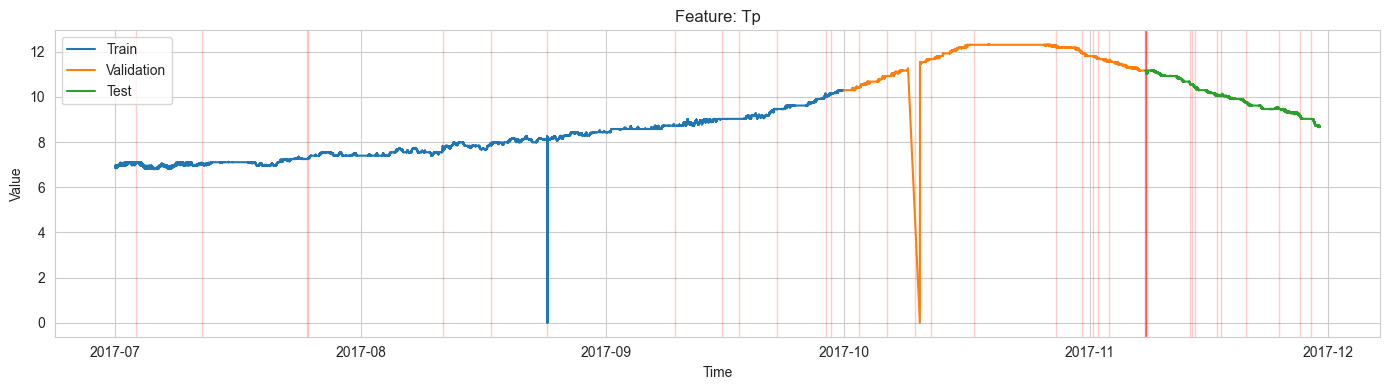

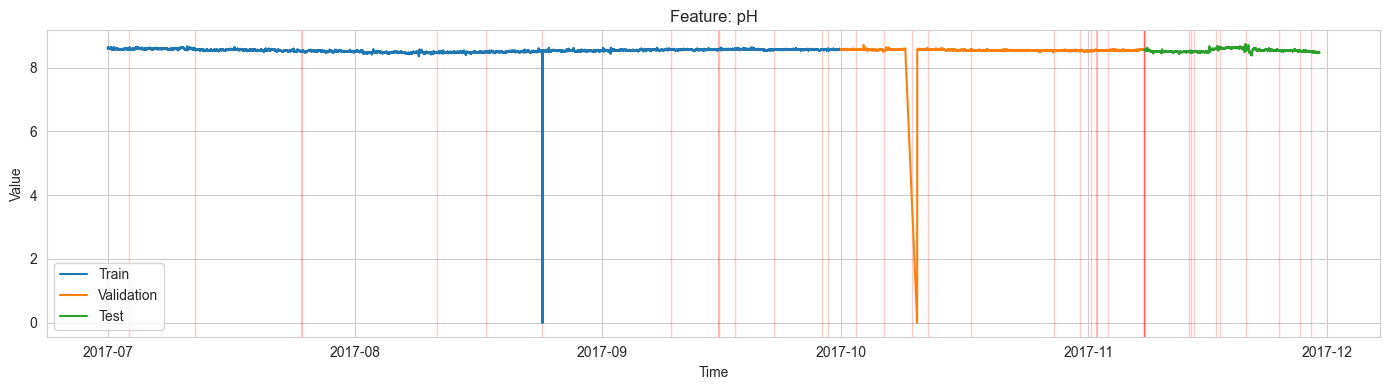

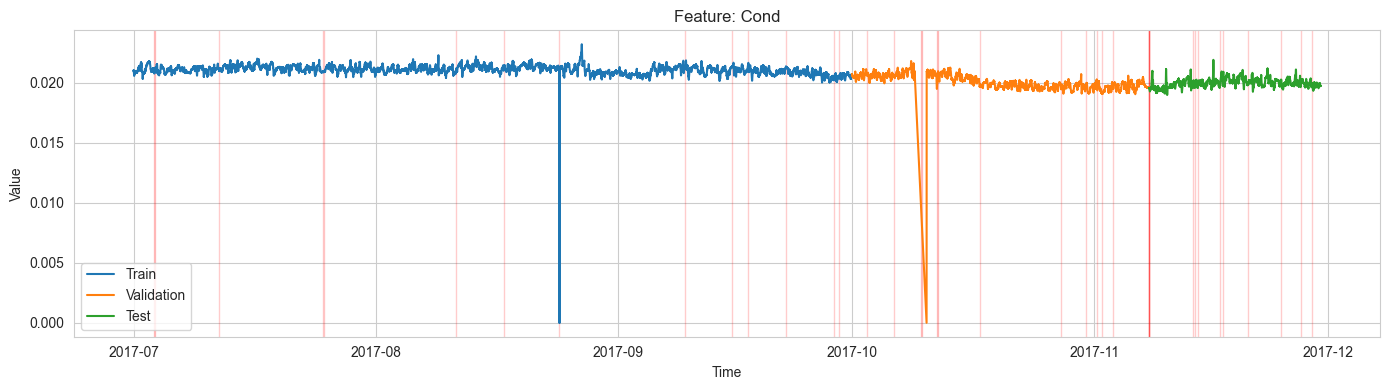

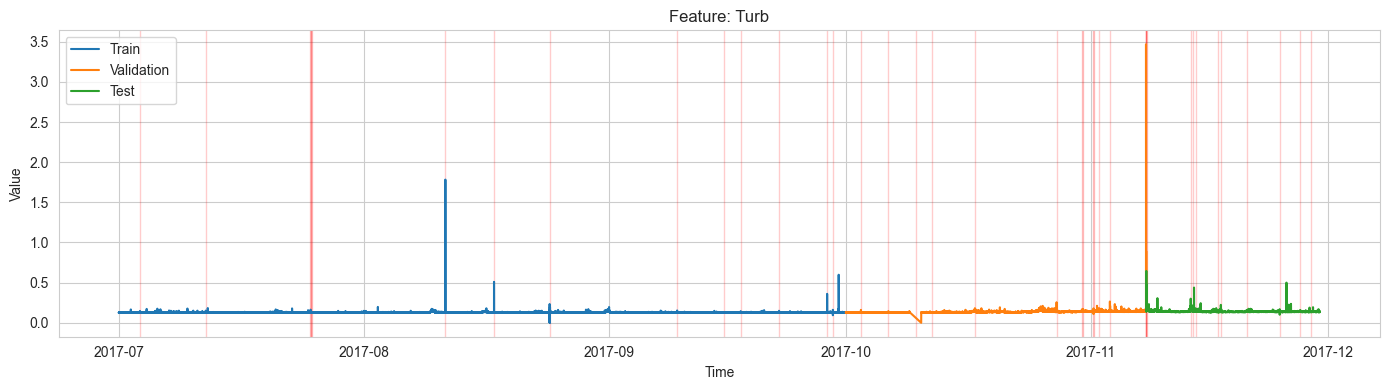

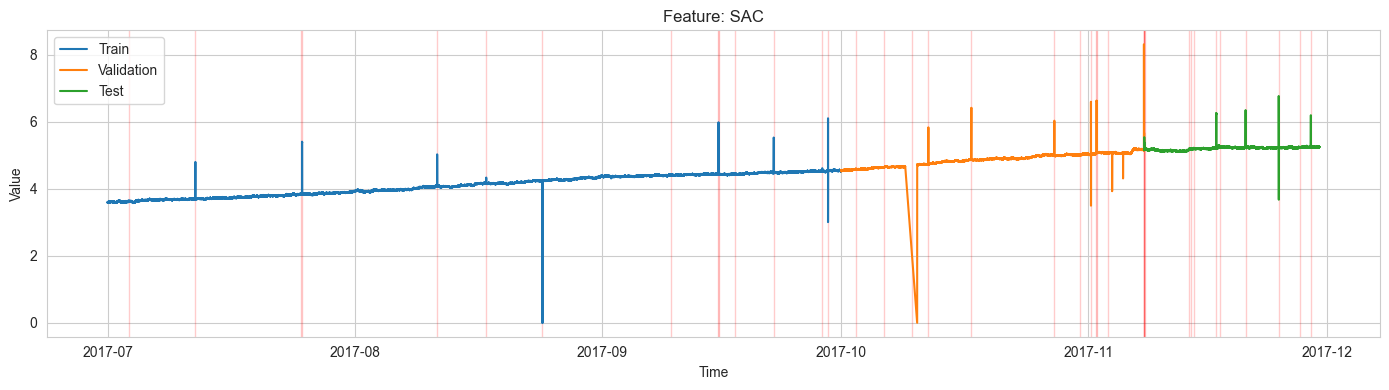

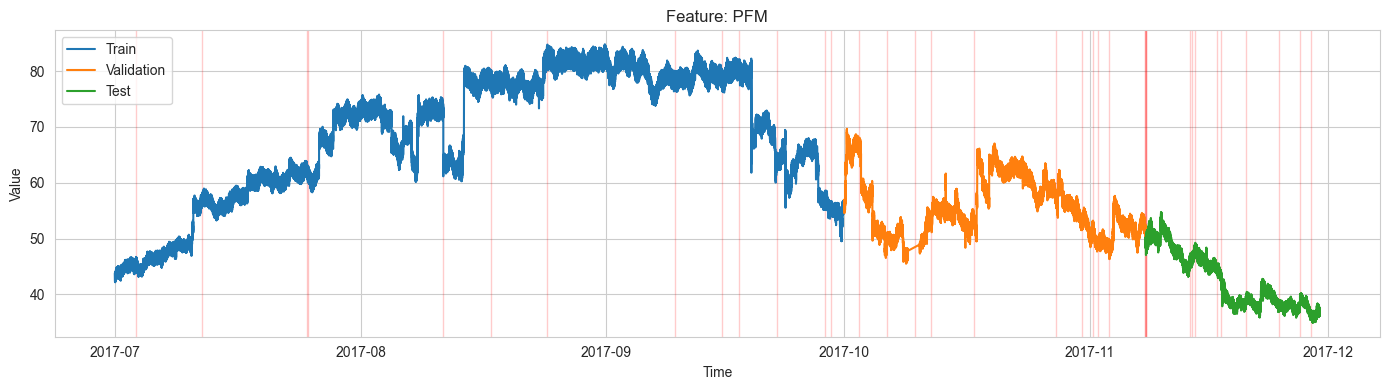

In [3]:
# Create a dictionary for easy iteration over the datasets
datasets = {
    'Train': data_train,
    'Validation': data_val,
    'Test': data_test
}

# Plot each feature over the full timespan and add red spans for contamination events
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Plot each dataset's feature
    for label, df in datasets.items():
        # Plot the feature values using the DataFrame index as x-axis.
        plt.plot(df[feature], label=label)

        # Highlight contamination periods
        util.highlight_contamination(df)

    plt.title(f"Feature: {feature}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Visualizing the Distribution of each Feature
But the true problem becomes more apparent when looking at the distribution of each feature. FOr a few features, the distributions of the train, validation, and test sets do not match at all. This makes it very difficult for models to generalize well to data not used during training.

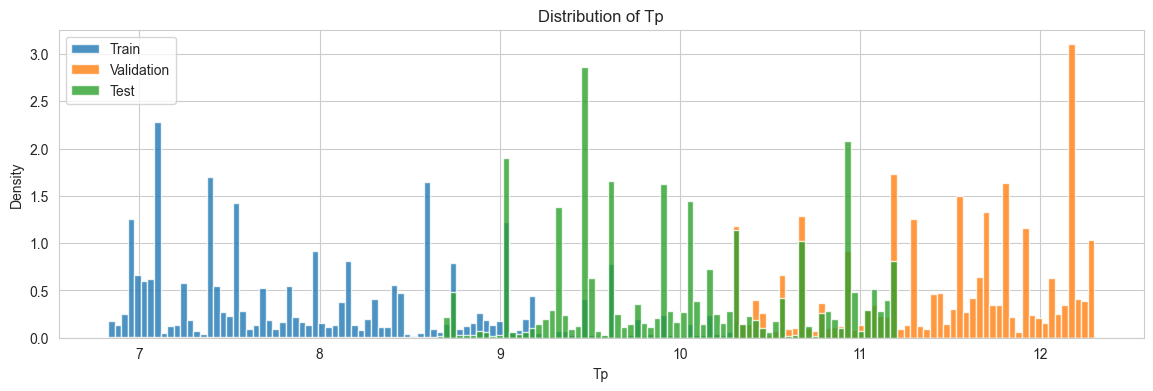

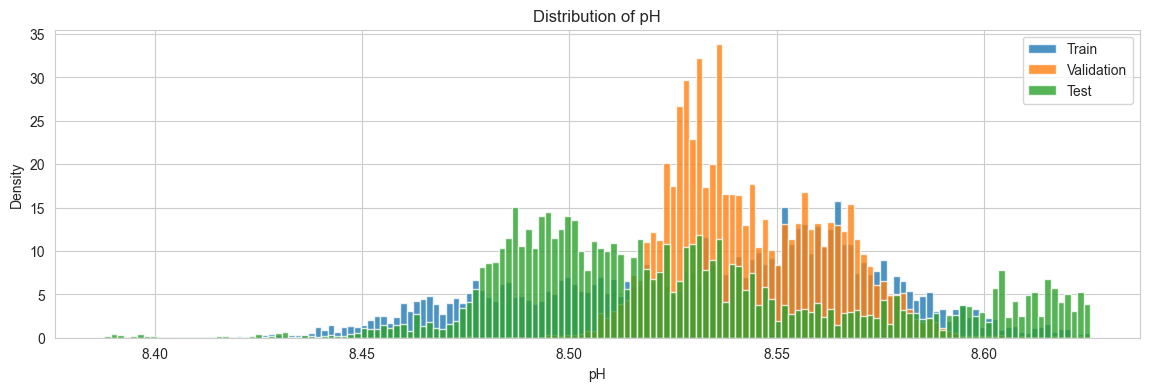

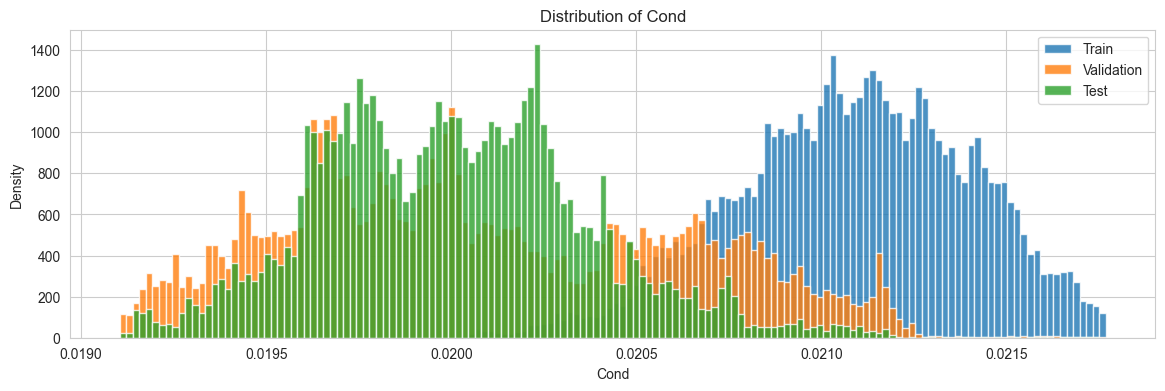

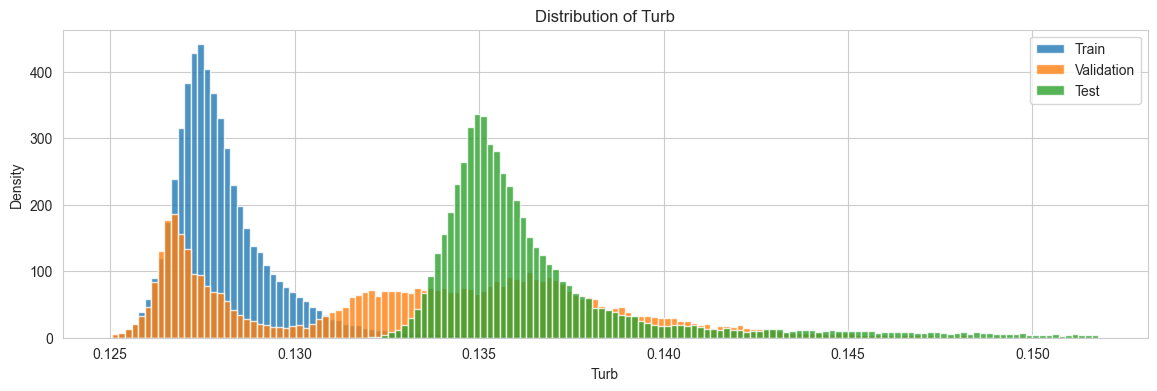

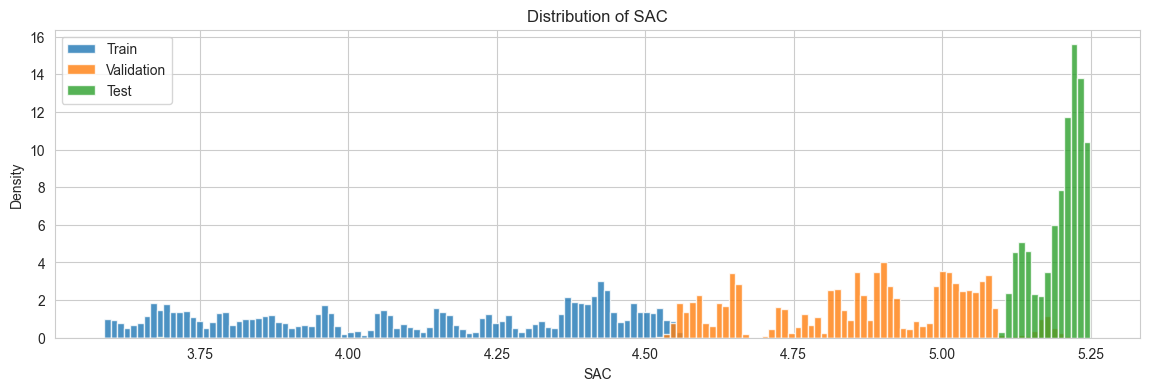

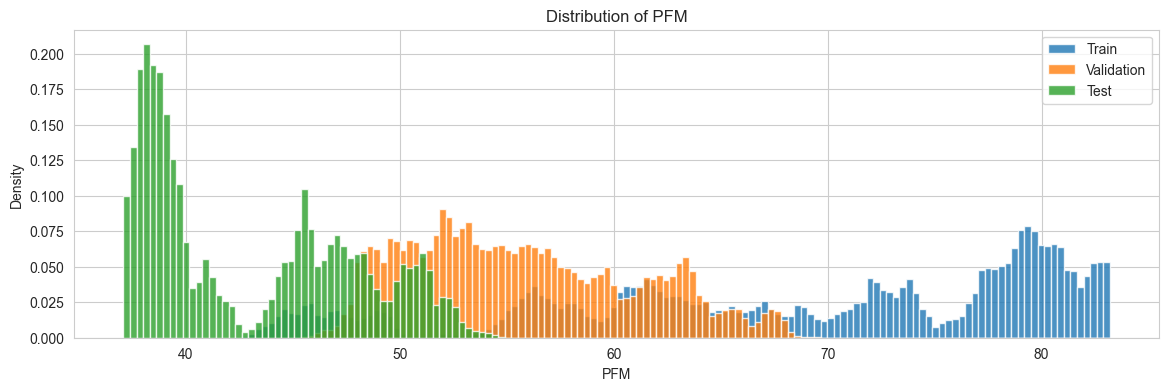

In [4]:
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Determine the overall minimum and maximum values from all datasets
    all_data = np.concatenate([data_train[feature], data_val[feature], data_test[feature]])

    # Remove outliers
    lower_threshold = np.percentile(all_data, 1)
    upper_threshold = np.percentile(all_data, 99)
    all_data = all_data[(all_data > lower_threshold) & (all_data < upper_threshold)]

    # Create 150 bins
    min_val, max_val = all_data.min(), all_data.max()
    bins = np.linspace(min_val, max_val, 151)

    # Set the x-axis limits
    margin = 0.05 * (max_val - min_val)  # 1% margin on each side
    plt.xlim(min_val - margin, max_val + margin)

    # Plot each dataset's feature
    for label, df in datasets.items():
        # Plot normalized histograms (density=True)
        plt.hist(df[feature], bins=bins, alpha=0.8, density=True, label=label)

    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Naive Trend Removal using Linear Regression
Let's try and detrend the data for the `SAC` feature using a simple linear regression model. The assumption here is that the trend is linear and can be modeled by a straight line. This approach is simple and fast but it may not be the best choice for all features. Furthermore, it assumes that all future observations not yet seen in the training, validation, or test sets also follow the same trend. Intuitively, this assumption is not always true as the spectral absorption coefficient cannot grow indefinitely. However, it is a good starting point for exploring detrending techniques.

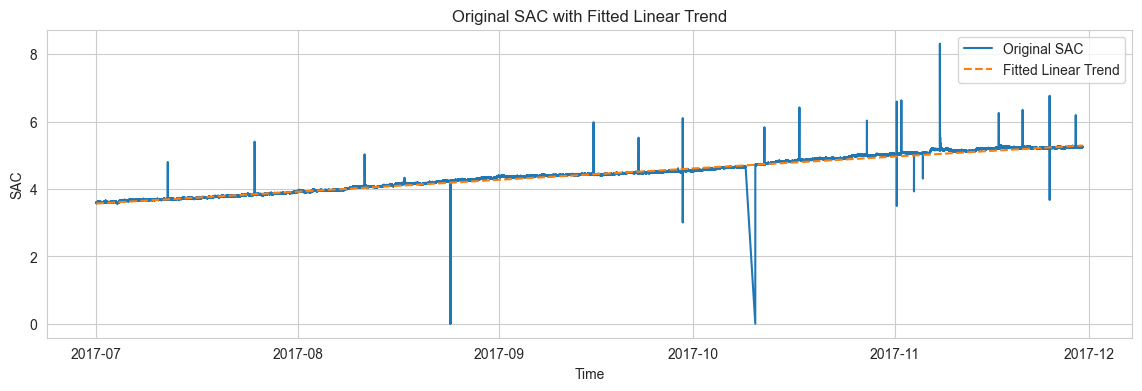

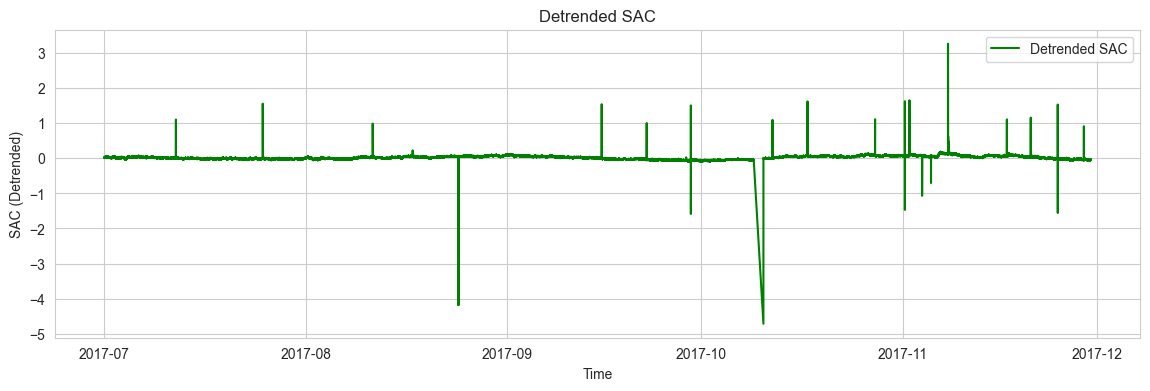

In [5]:
# Combine the training, validation, and test sets into a single DataFrame
df_combined = pd.concat([data_train, data_val, data_test], axis=0)

# Create a numeric time variable (e.g., seconds elapsed since the start)
df_combined['time_num'] = (df_combined.index - df_combined.index[0]).total_seconds()

# Fit a linear regression model to 'SAC' over time
X = df_combined[['time_num']]
y = df_combined['SAC']
lr = LinearRegression()
lr.fit(X, y)

# Get the fitted trend
df_combined['trend'] = lr.predict(X)

# Remove the trend (detrend the data)
df_combined['SAC_detrended'] = df_combined['SAC'] - df_combined['trend']

# Plot original data
plt.figure(figsize=figsize)
plt.plot(df_combined.index, df_combined['SAC'], label='Original SAC')
plt.plot(df_combined.index, df_combined['trend'], label='Fitted Linear Trend', linestyle='--')
plt.title('Original SAC with Fitted Linear Trend')
plt.xlabel('Time')
plt.ylabel('SAC')
plt.legend()
plt.show()

# Plot detrended data
plt.figure(figsize=figsize)
plt.plot(df_combined.index, df_combined['SAC_detrended'], label='Detrended SAC', color='green')
plt.title('Detrended SAC')
plt.xlabel('Time')
plt.ylabel('SAC (Detrended)')
plt.legend()
plt.show()

For the observed global trend of the `SAC` feature, we see that the linear regression model is a good fit. We could now continue and do similar things for the other features. For example, we could remove the sine wave trend from the `Tp` feature using Harmonic Regression. But this approach is limited to our visual observations and may not reflect the real underlying trend in the data.

## Detrending using a Moving Average
A more promising approach that is independent of the underlying trend is to use a moving average to remove the trend. This approach is more robust to changes in the trend and can be applied to a wider range of features. It works by calculating the average of a window of observations and subtracting it from the original observations. The important parameter here is the window size.

A small window is more responsive to local changes but retains more noise in the data. Furthermore, a small window causes the detrended data to have a higher variance. If the window size is too small, the trend may be missed.

Larger windows smooth out noise much better but this also introduces lag which may cause a model to miss or delay detecting significant trend changes. Also, smoothing the data too much can cause important outliers to vanish.

In [6]:
# Define a reasonable window size (4 hours)
window_size = 4 * 60

# Apply a moving average detrending to the dataset
data_train_detrended = util.apply_detrending(data_train, window_size=window_size)
data_val_detrended = util.apply_detrending(data_val, window_size=window_size)
data_test_detrended = util.apply_detrending(data_test, window_size=window_size)

## Visualizing the Detrended Features
Let's have a look at the detrended features again. The global trends are gone completely. This is a good sign that the trends have been removed effectively.

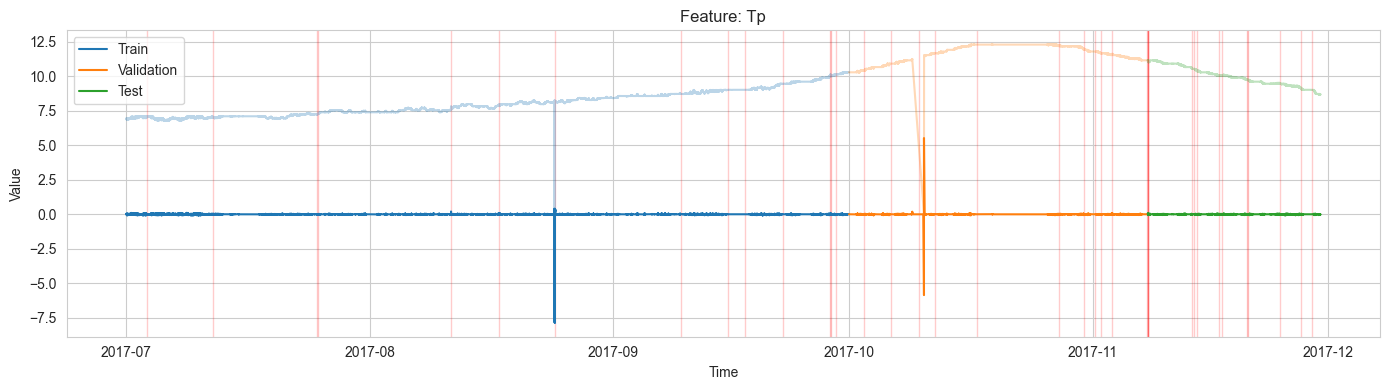

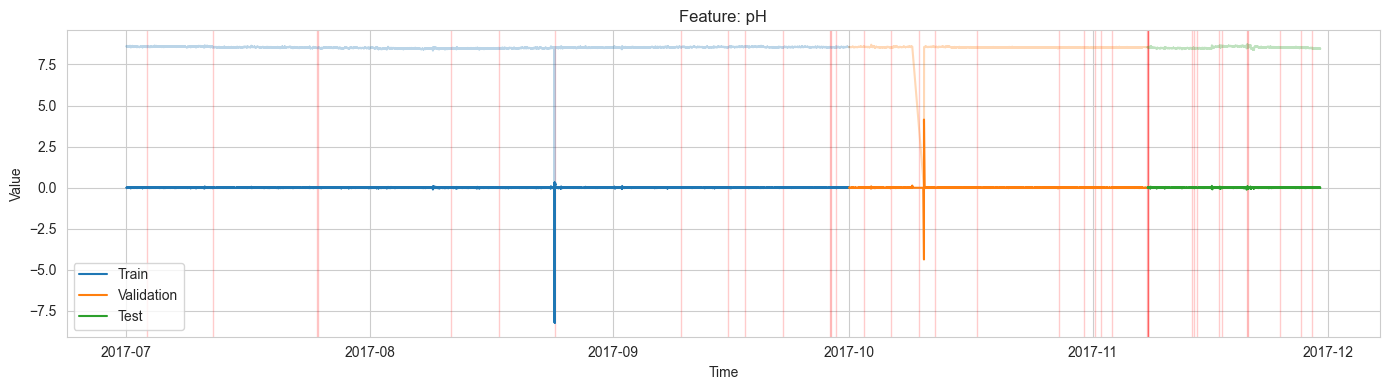

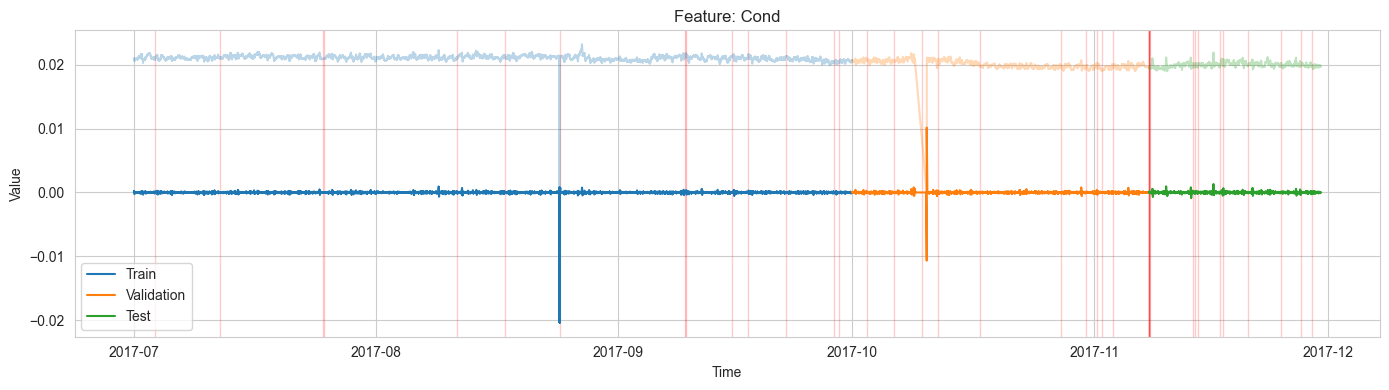

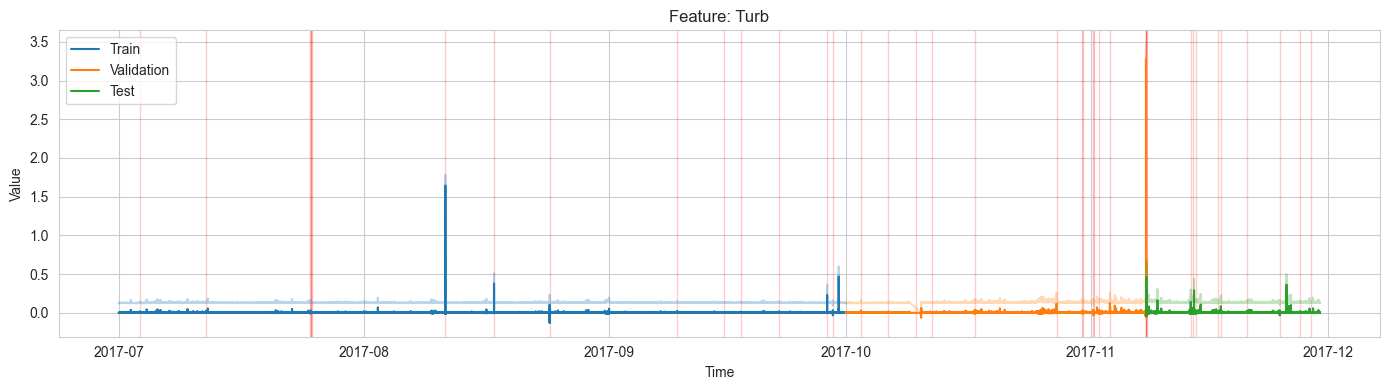

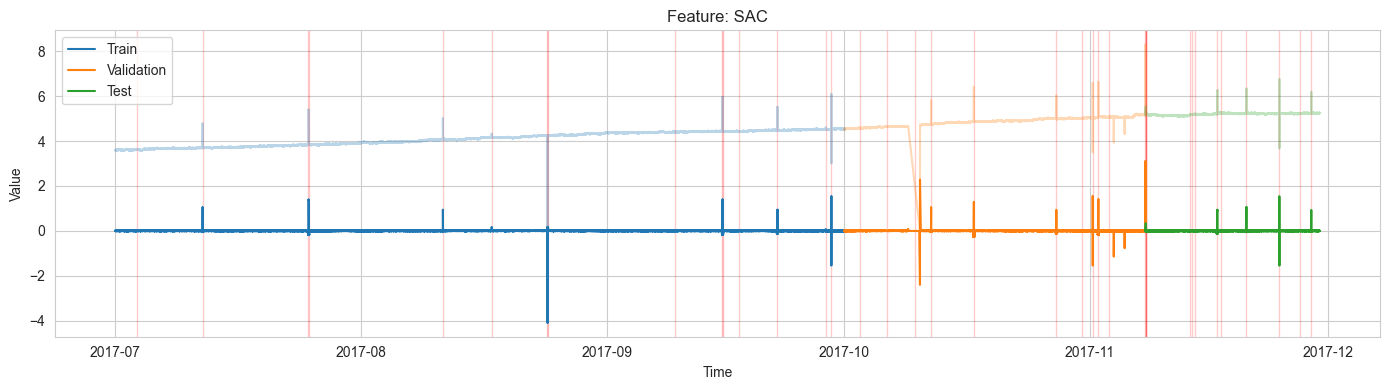

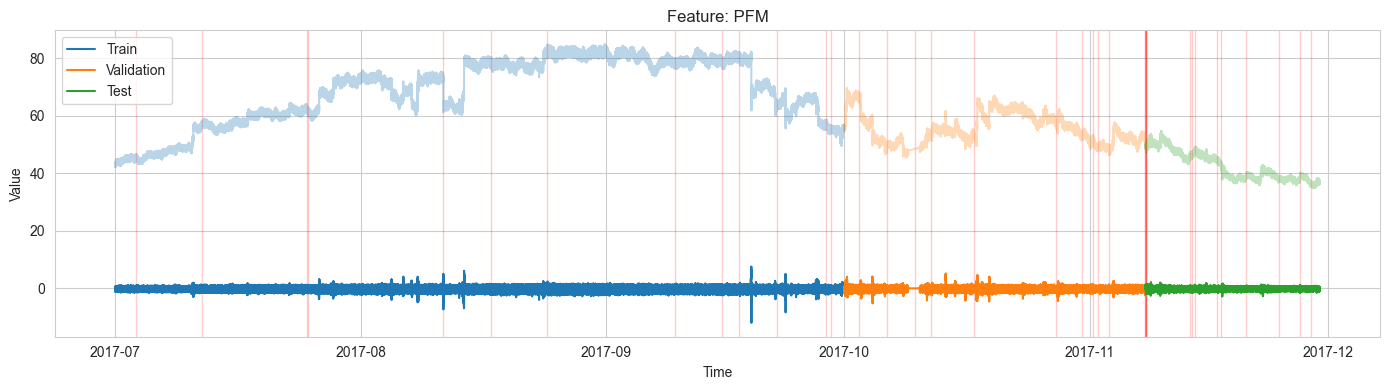

In [7]:
# Create a dictionary for easy iteration over the datasets for the detrending analysis
datasets_detrended = {
    'Train': ('C0', data_train, data_train_detrended),
    'Validation': ('C1', data_val, data_val_detrended),
    'Test': ('C2', data_test, data_test_detrended)
}

# Plot each feature over the full timespan and add red spans for contamination events
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Plot each dataset's feature
    for label, dfs in datasets_detrended.items():
        color, df, detrended_df = dfs

        # Plot the feature values using the DataFrame index as x-axis.
        plt.plot(detrended_df[feature], label=label, color=color)
        plt.plot(df[feature], color=color, alpha=0.3)

        # Highlight contamination periods
        util.highlight_contamination(df)

    plt.title(f"Feature: {feature}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Visualizing the Detrended Distribution of each Feature
A look at the distribution plots for each feature shows that the distributions of the features are more similar to each other. This makes it much easier for models to generalize well to unseen data and learn to identify contamination events based on local variations instead of global trends.

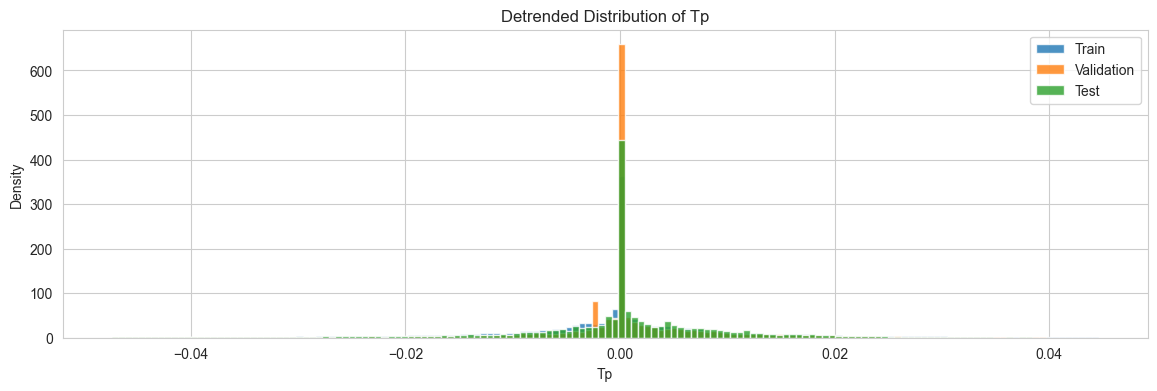

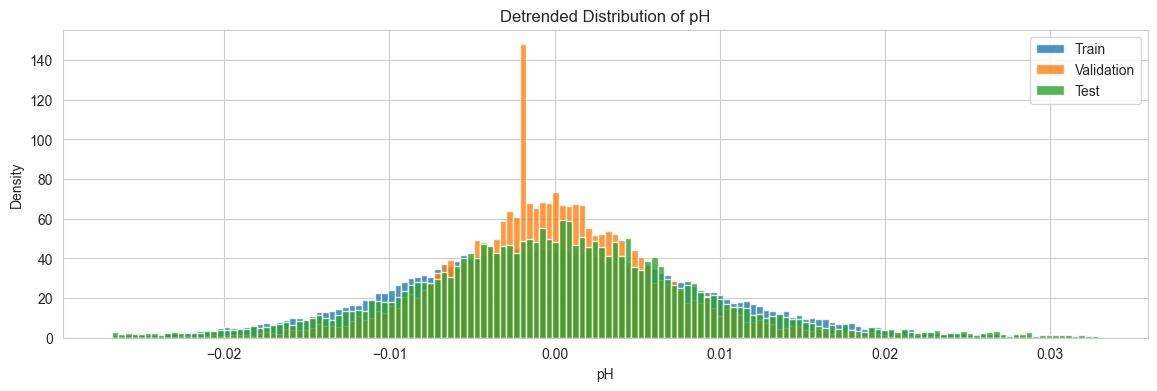

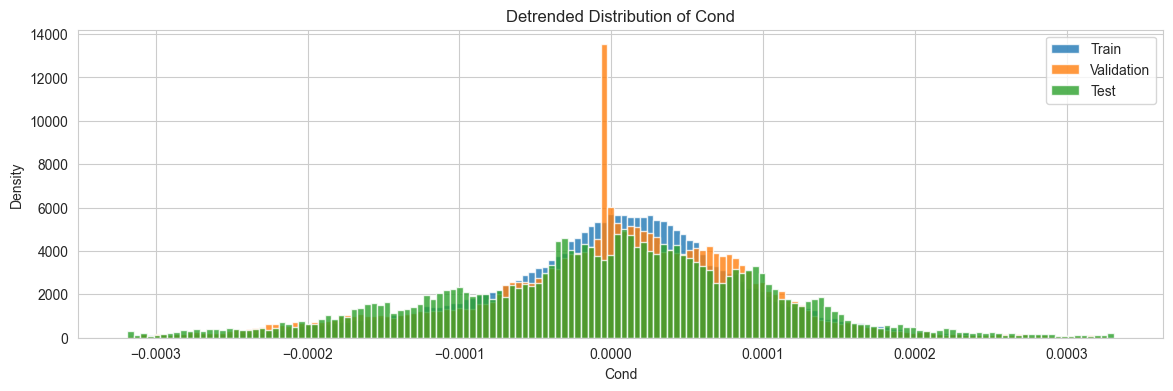

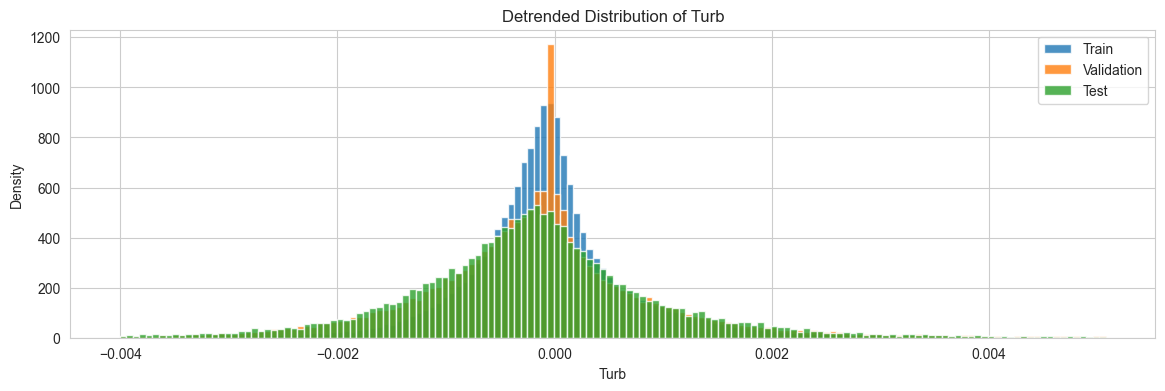

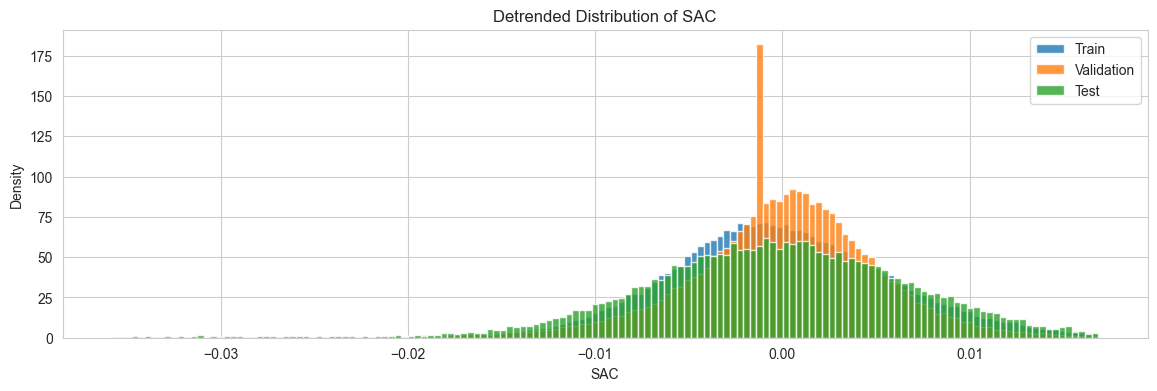

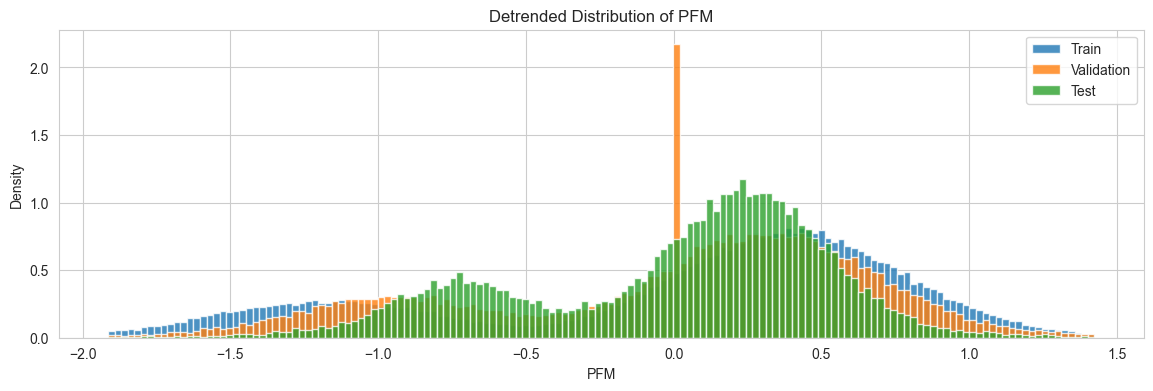

In [8]:
for feature in feature_columns:
    plt.figure(figsize=figsize)

    # Determine the overall minimum and maximum values from all datasets
    all_data = np.concatenate([data_train_detrended[feature], data_val_detrended[feature], data_test_detrended[feature]])

    # Remove outliers
    lower_threshold = np.percentile(all_data, 1)
    upper_threshold = np.percentile(all_data, 99)
    all_data = all_data[(all_data > lower_threshold) & (all_data < upper_threshold)]

    # Create 150 bins
    min_val, max_val = all_data.min(), all_data.max()
    bins = np.linspace(min_val, max_val, 151)

    # Set the x-axis limits
    margin = 0.05 * (max_val - min_val)  # 1% margin on each side
    plt.xlim(min_val - margin, max_val + margin)

    # Plot each dataset's feature
    for label, dfs in datasets_detrended.items():
        color, df, detrended_df = dfs

        # Plot normalized histograms (density=True)
        plt.hist(detrended_df[feature], bins=bins, alpha=0.8, density=True, label=label)

    plt.title(f'Detrended Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Autocorrelation Plot for Detrended Data
Finally, the autocorrelation plot for the detrended data shows that the temporal correlation is reduced significantly. There are still some features which show a recurring pattern but their frequency is much lower than in the raw data. After all, the correlation is mostly between -0.02 and 0.02 which is a good sign that trends and patters have been removed effectively.

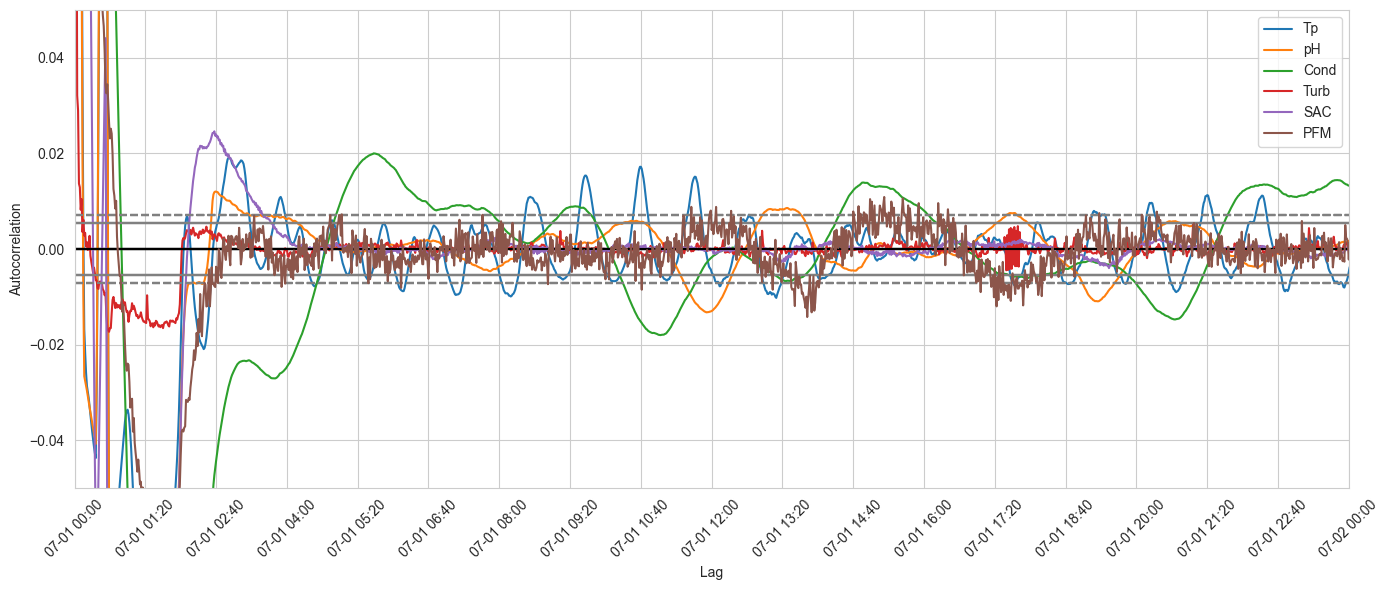

In [9]:
# Prepare the data for the autocorrelation plot
sample_delta = (data_train_detrended.index[1] - data_train_detrended.index[0])
data_autocorrelation = [data_train_detrended[c] for c in feature_columns]

# Plot the autocorrelation for each feature
util.plot_multiple_autocorrelations(data_autocorrelation, pd.Timedelta(days=1) / sample_delta, figsize=(figsize[0], 6), ylim=(-0.05, 0.05))

## Choosing the Ideal Window Size
The choice of the window size is critical for the success of the detrending approach.

A small sliding window tends to follow the data too closely. It captures a lot of the short-term noise or fluctuations, which means that the estimated trend might still contain much of the high-frequency variation. This can make it difficult to isolate the true underlying trend, resulting in a high-variance, low-bias estimate.

On the other hand, a very large sliding window provides a smoother trend estimate by averaging over many points. While this reduces noise (lower variance), it can oversmooth the data and introduce lag. As a result, important local changes or rapid shifts in the trend may be obscured, leading to a high-bias, low-variance estimate.

The final window size of 4 hours was chosen based on the results of the previous analysis. It turned out to be a good compromise between the two extremes by providing a balance between noise reduction and trend isolation.

